In [5]:
# libraries
import pandas as pd 
import numpy as np
from datetime import timedelta, datetime

In [11]:
url = "https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-latest.csv"

# import data
df  = pd.read_csv(url)
df.data_somministrazione = pd.to_datetime(df.data_somministrazione)

# keep data after 2021-01-01
df = df.loc[df.data_somministrazione>=datetime(2021, 1, 1)].reset_index(drop=True)

# keep only selected columns
df = df[["data_somministrazione", "fascia_anagrafica", "prima_dose", "seconda_dose"]]

# group by date and age group 
df_grouped = df.groupby(by=["data_somministrazione", "fascia_anagrafica"], as_index=False).sum()

# add missing data on 2021-01-03
df_grouped = df_grouped.append({"data_somministrazione": datetime(2021, 1, 3), 
                                "fascia_anagrafica": "12-19",
                                "prima_dose": 0, 
                                "seconda_dose": 0}, ignore_index=True)

# sort by date 
df_grouped.sort_values(by=["data_somministrazione", "fascia_anagrafica"], inplace=True, ignore_index=True)
df_grouped.head()

,data_somministrazione,fascia_anagrafica,prima_dose,seconda_dose
0,2021-01-01,12-19,3,0
1,2021-01-01,20-29,919,0
2,2021-01-01,30-39,1945,0
3,2021-01-01,40-49,2424,0
4,2021-01-01,50-59,3205,0


In [12]:
df_grouped.fascia_anagrafica.unique()

array(['12-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79',
       '80-89', '90+'], dtype=object)

In [13]:
# map to our age groups 
vaccinations = {}
ages = ['12-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

date = datetime(2021, 1, 1)
while date <= datetime(2021, 6, 2):
    
    vaccinations[date] = np.zeros(16) # n. of our age groups
    for age in ages: 
        df_date_age = df_grouped.loc[(df_grouped.data_somministrazione == date) & (df_grouped.fascia_anagrafica == age)]

        if age == '12-19':
            
            vaccinations[date][0] += df_date_age["prima_dose"].values[0] / 4 # 0-4
            vaccinations[date][1] += df_date_age["prima_dose"].values[0] / 4 # 5-9
            vaccinations[date][2] += df_date_age["prima_dose"].values[0] / 4 # 10-14
            vaccinations[date][3] += df_date_age["prima_dose"].values[0] / 4 # 15-19
            
        elif age == '20-29':
            
            vaccinations[date][4] += df_date_age["prima_dose"].values[0] / 2 # 20-24
            vaccinations[date][5] += df_date_age["prima_dose"].values[0] / 2 # 25-29
            
        elif age == '30-39':
            
            vaccinations[date][6] += df_date_age["prima_dose"].values[0] / 2 # 30-34
            vaccinations[date][7] += df_date_age["prima_dose"].values[0] / 2 # 35-39
            
        elif age == '40-49':
            
            vaccinations[date][8] += df_date_age["prima_dose"].values[0] / 2 # 40-44
            vaccinations[date][9] += df_date_age["prima_dose"].values[0] / 2 # 45-49
            
        elif age == '50-59':
            
            vaccinations[date][10] += df_date_age["prima_dose"].values[0] / 2 # 50-54
            vaccinations[date][11] += df_date_age["prima_dose"].values[0] / 2 # 55-59
            
        elif age == '60-69':
            
            vaccinations[date][12] += df_date_age["prima_dose"].values[0] / 2 # 60-64
            vaccinations[date][13] += df_date_age["prima_dose"].values[0] / 2 # 65-69
            
        elif age == '70-79':
            
            vaccinations[date][14] += df_date_age["prima_dose"].values[0] / 2 # 70-74
            vaccinations[date][15] += df_date_age["prima_dose"].values[0] / 2 # 75+
            
        elif age == '80-89':
            vaccinations[date][15] += df_date_age["prima_dose"].values[0] # 75+
            
        elif age == '90+':
            vaccinations[date][15] += df_date_age["prima_dose"].values[0] # 75+
    
    date += timedelta(days=1)
    
import pickle as pkl
with open("../countries/Italy/vaccinations/vaccinations.pkl", "wb") as file:
    pkl.dump(vaccinations, file)

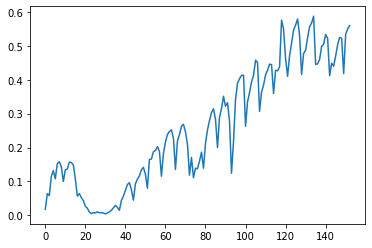

In [15]:
tot = []
date = datetime(2021, 1, 1)
while date <= datetime(2021, 6, 2):
    tot.append(np.sum(vaccinations[date]))
    date += timedelta(days=1)
import matplotlib.pyplot as plt
plt.plot((100 * np.array(tot) / (60*10**6))[0:170])

# AGE GROUPS BY CATEGORY

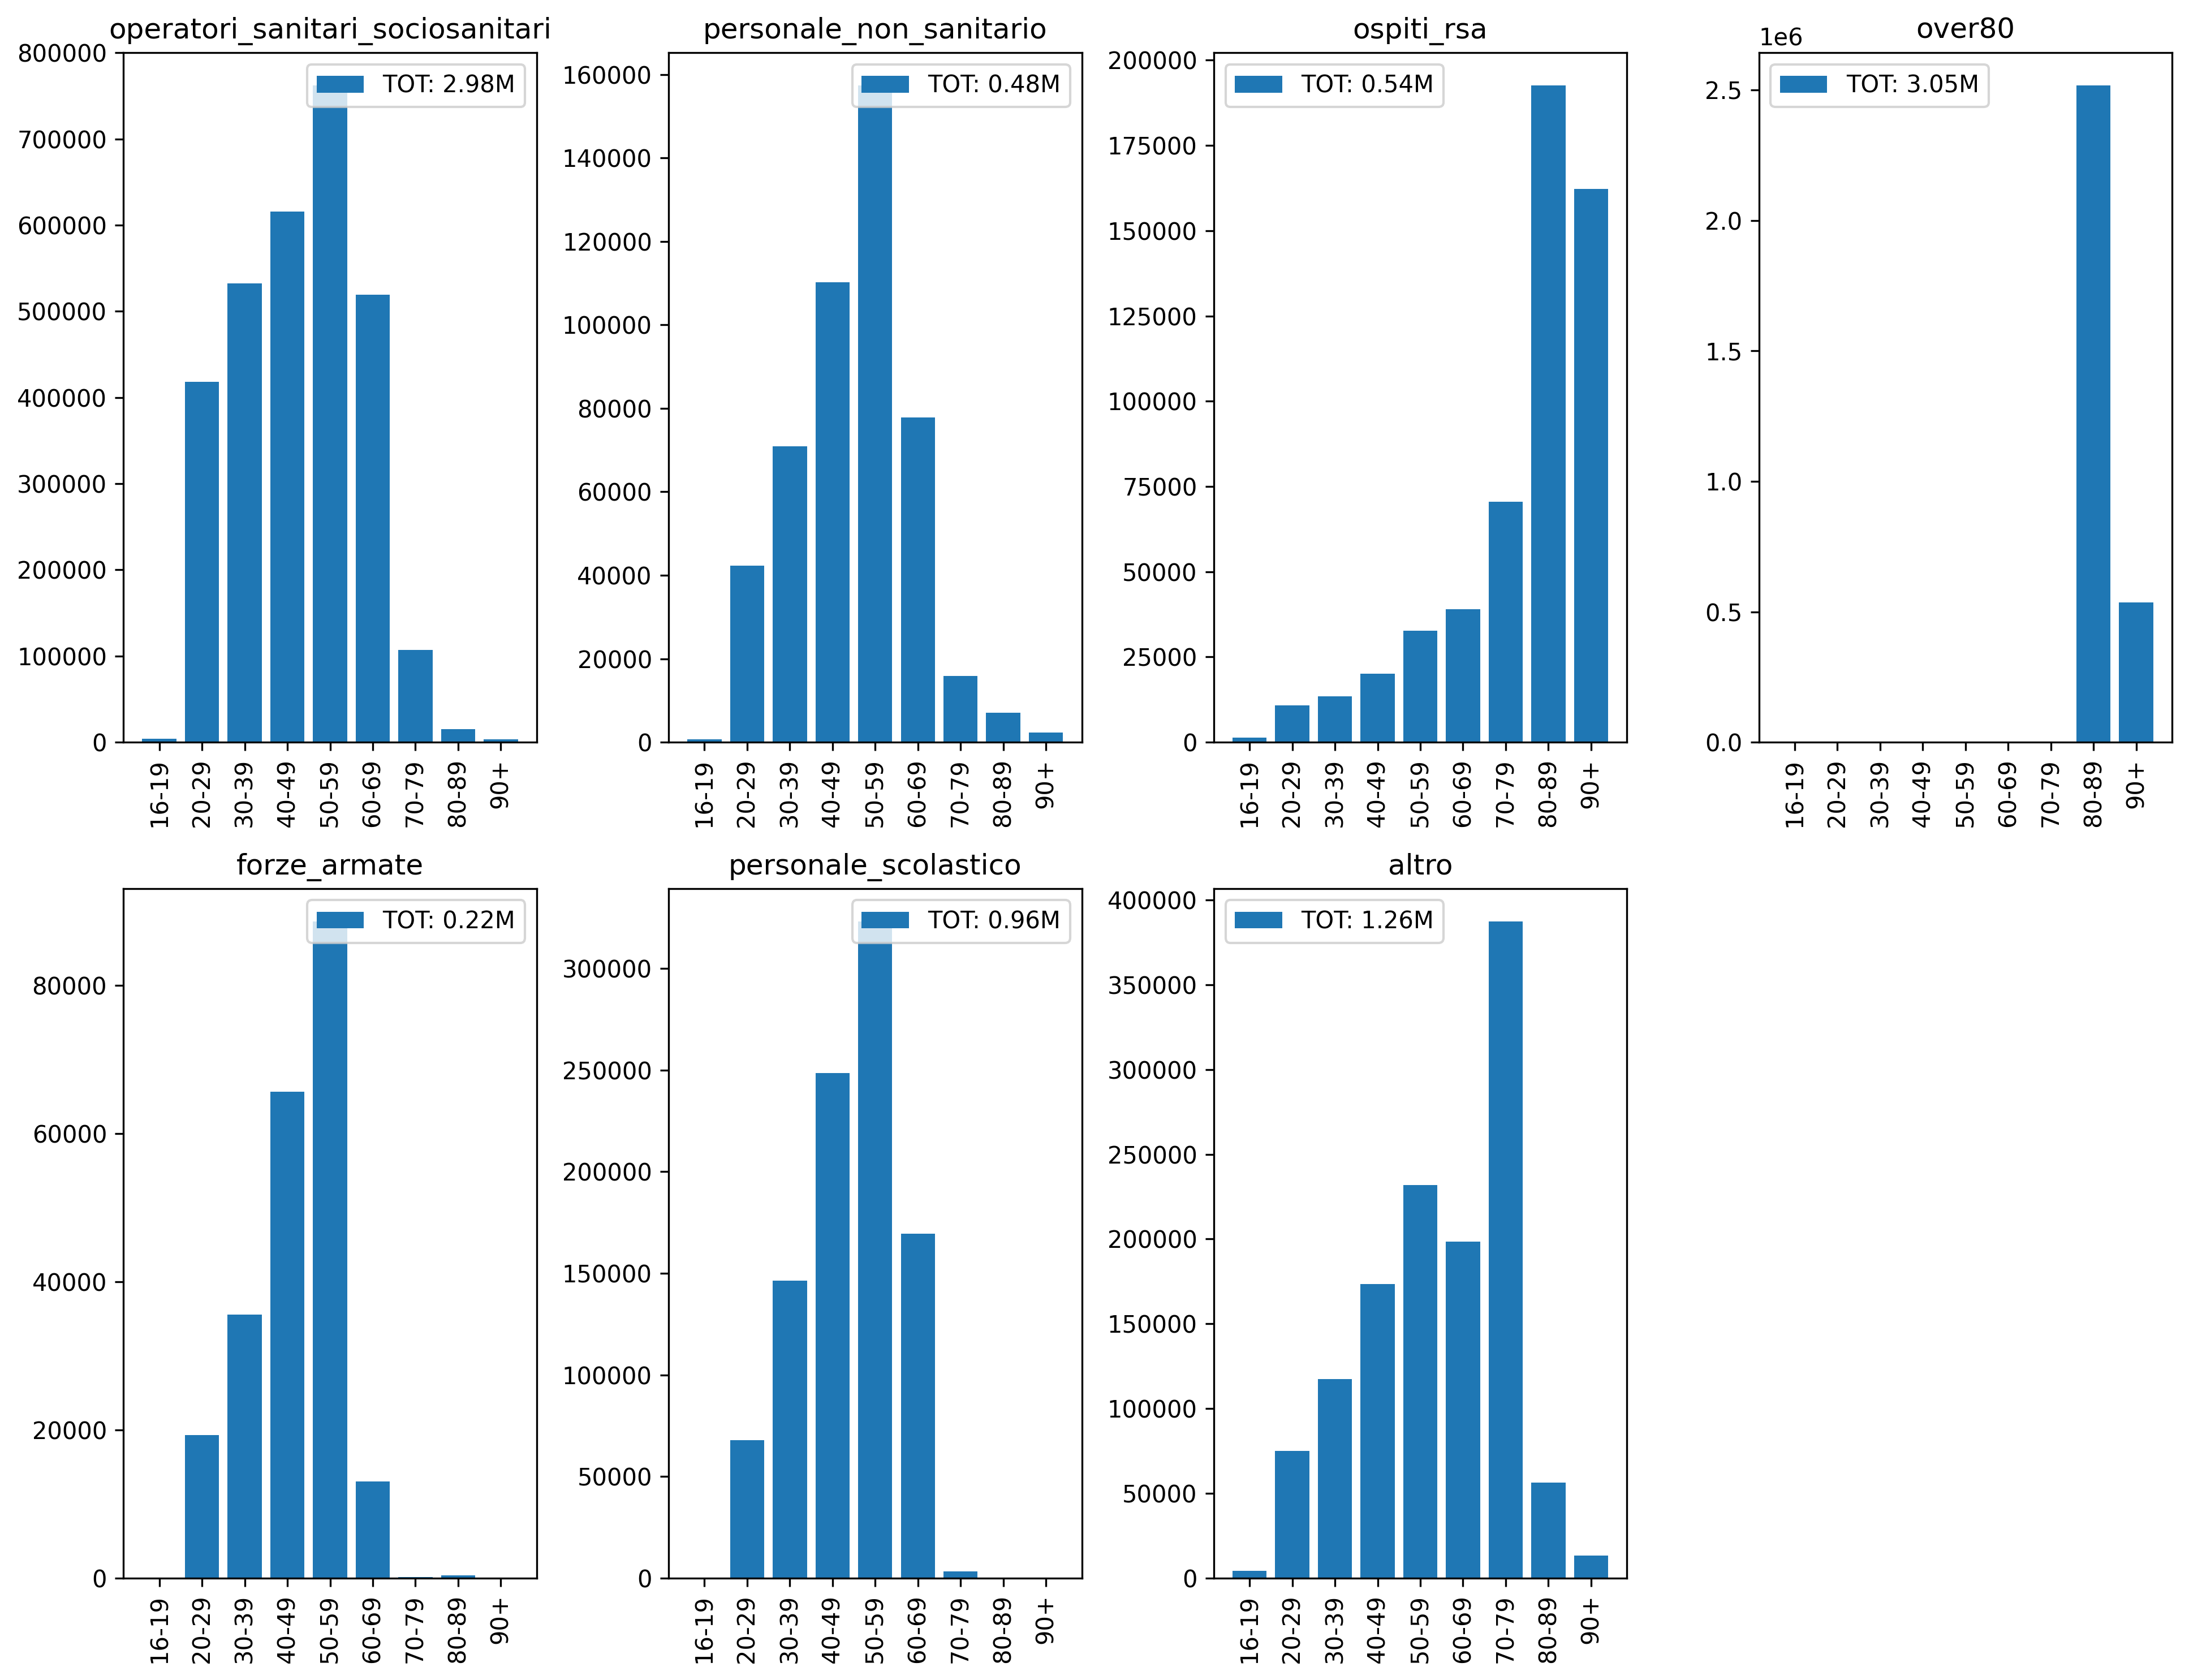

In [48]:
import matplotlib.pyplot as plt
url = "https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-latest.csv"

# import data
df  = pd.read_csv(url)

categories = ['categoria_operatori_sanitari_sociosanitari',
              'categoria_personale_non_sanitario', 
              'categoria_ospiti_rsa',
              'categoria_over80', 
              'categoria_forze_armate',
              'categoria_personale_scolastico', 
              'categoria_altro']


fig, axes = plt.subplots(dpi=300, nrows=2, ncols=4, figsize=(13,10))
category = categories[0]

i, j = 0, 0
for category in categories:

    # keep only selected columns
    df_cat = df[["fascia_anagrafica", category]]
    df_grouped = df_cat.groupby(by=["fascia_anagrafica"], as_index=False).sum()

    # label
    label = "TOT: " + str(np.round(df_grouped[category].sum() / 10**6, 2)) + "M"
    
    # group by date and age group 
    parse_age  = lambda string : (int(string.split("-")[0]) + int(string.split("-")[1])) / 2 if string!="90+" else 95
    axes[i,j].bar(df_grouped.fascia_anagrafica, df_grouped[category], label=label)
    axes[i,j].set_title(category.replace("categoria_", ""))
    axes[i,j].tick_params(axis="x", rotation=90)
    axes[i,j].legend()
    
    j += 1
    if j == 4:
        i += 1 
        j = 0
        
axes[1,3].axis('off')
plt.tight_layout()